In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
timestamp = ['timestamp']
p = ['p_x', 'p_y', 'p_z']
q = ['q_w', 'q_x', 'q_y', 'q_z']
v = ['v_x', 'v_y', 'v_z']
w = ['w_x', 'w_y', 'w_z']
a = ['a_x', 'a_y', 'a_z']

In [3]:
def load_imu(filepath, file_type=0):
    # file_type = 0 -> (timestamp, w, a)
    #             1 -> (timestamp, q, w, a)
    #             2 -> (timestamp, p, q, v, w, a)
    if file_type == 0:
        names = timestamp + w + a
    elif file_type == 1:
        names = timestamp + q + w + a
    else:
        names = timestamp + p + q + v + w + a
    
    return np.genfromtxt(filepath, delimiter=',', names=names)

In [40]:
def plot_data(x_arg, y_arg, data_list, data_labels, 
              alpha=1, title='', x_label='', y_label=''):
    
    mpl.rcParams['legend.fontsize'] = 10    
    fig = plt.figure(figsize=(13, 4))
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    for data, label in zip(data_list, data_labels):
        x = data[x_arg]
        y = data[y_arg]       
        plt.plot(x, y, label=label, alpha=alpha)
    
    plt.legend()    
    plt.show()

def plot_components(data, measure='a', title='', alpha=1):
    mpl.rcParams['legend.fontsize'] = 10    
    fig = plt.figure(figsize=(13, 4))
    plt.title(title)
    x = data['timestamp']
    plt.xlabel('timestamp (ns)')
    if measure == 'a':     
        plt.ylabel('acceleration (m/s²)')
        plt.plot(x, data['a_x'], label='$a_x$', alpha=alpha)
        plt.plot(x, data['a_y'], label='$a_y$', alpha=alpha)
        plt.plot(x, data['a_z'], label='$a_z$', alpha=alpha)
    elif measure == 'w':
        plt.ylabel('angular velocity (rad/s)')
        plt.plot(x, data['w_x'], label='$w_x$', alpha=alpha)
        plt.plot(x, data['w_y'], label='$w_y$', alpha=alpha)
        plt.plot(x, data['w_z'], label='$w_z$', alpha=alpha)
        
    plt.legend()    
    plt.show()
    
def plot_module_data(data_list, data_labels, alpha=1,
              title='', x_label='', y_label=''):
    
    mpl.rcParams['legend.fontsize'] = 10    
    fig = plt.figure(figsize=(13, 4))
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
        
    for data, label in zip(data_list, data_labels):
        x = data[:, 0]
        y = data[:, 1]       
        plt.plot(x, y, alpha=alpha, label=label)
    
    plt.legend()    
    plt.show()

In [5]:
def sync_data_with_fps(data, hz, fps):
    step = hz // fps
    size = data.shape[0]
    new_size = size // step
    data_sync = np.zeros((new_size,), dtype=data.dtype)
    for i in range(new_size):
        i_start = i*step
        i_end   = i_start + step
        for name in data.dtype.names:
            if name == 'timestamp':
                data_sync[name][i] = data[name][i] 
            else: 
                data_sync[name][i] = np.median(data[name][i_start:i_end])

    return data_sync

In [6]:
def module(data, unit='a'):
    if unit == 'a':
        sqrt = np.sqrt(data['a_x']**2 + data['a_y']**2 + data['a_z']**2)
    elif unit == 'w':
        sqrt = np.sqrt(data['w_x']**2 + data['w_y']**2 + data['w_z']**2)
    elif unit == 'v':
        sqrt = np.sqrt(data['v_x']**2 + data['v_y']**2 + data['v_z']**2)
    else:
        return
    return np.vstack((data['timestamp'], sqrt)).T

In [7]:
def calculate_acceleration(data):
    size = data.shape[0]
    data_a = np.zeros((size-1,), dtype=data.dtype)
    
    data_a['timestamp'] = data['timestamp'][:-1]
    for i in range(size-2):
        dt = (data[i+1]['timestamp'] - data[i]['timestamp']) * 1e-9  # ns to s
        data_a['a_x'][i] = (data['v_x'][i+1] - data['v_x'][i]) / dt
        data_a['a_y'][i] = (data['v_y'][i+1] - data['v_y'][i]) / dt
        data_a['a_z'][i] = (data['v_z'][i+1] - data['v_z'][i]) / dt
    return data_a

def clean_gt_acceleration(gt_acceleration, cache_size=10):
    old_size = gt_acceleration.shape[0]
    new_size = old_size // cache_size
    data = np.zeros((new_size,), dtype=gt_acceleration.dtype)
    for i, r in enumerate(range(0, old_size, cache_size)[:-1]):      
        data['timestamp'][i] = gt_acceleration['timestamp'][r]
        data['a_x'][i]       = np.mean(gt_acceleration['a_x'][r:r+cache_size])
        data['a_y'][i]       = np.mean(gt_acceleration['a_y'][r:r+cache_size])
        data['a_z'][i]       = np.mean(gt_acceleration['a_z'][r:r+cache_size])

    return data

In [8]:
class Accelerometer:
    def __init__(self):
        self.acceleration =        np.zeros(3, np.float)
        self.gravity =             np.zeros(3, np.float)
        self.linear_acceleration = np.zeros(3, np.float)
        
        self._t = 0.27  # same value as SDSlam
    
    def update(self, acceleration, dt):
        alpha = self._t / (self._t + dt)
        self.gravity = alpha*self.gravity + (1-alpha)*acceleration
        self.linear_acceleration = acceleration - self.gravity
        self.acceleration = acceleration
        

In [9]:
# https://developer.android.com/reference/android/hardware/SensorEvent.html
def imu_to_linear_acceleration(data):
    accelerometer = Accelerometer()
    size = data.shape[0]
    data_a = np.zeros((size-1,), dtype=data.dtype)
    
    data_a['timestamp'] = data['timestamp'][:-1]
    for i in range(size-2):
        dt = (data[i+1]['timestamp'] - data[i]['timestamp']) * 1e-9  # ns to s
        
        acceleration = np.array([data['a_x'][i], data['a_y'][i], data['a_z'][i]])
        accelerometer.update(acceleration, dt)
        
        data_a['a_x'][i] = accelerometer.linear_acceleration[0]
        data_a['a_y'][i] = accelerometer.linear_acceleration[1]
        data_a['a_z'][i] = accelerometer.linear_acceleration[2]
    del accelerometer
    return data_a

---

In [10]:
GT_FILE =  './data/EuRoC_V1_02/gt.csv'
IMU_FILE = './data/EuRoC_V1_02/sensors/imu.csv'
IMU_SYNC_SDSLAM = './data/EuRoC_V1_02/sdslam/imu_sync.csv'

In [11]:
gt = load_imu(GT_FILE, 2)
imu_sensor = load_imu(IMU_FILE, 0)
imu_msg = load_imu(IMU_SYNC_SDSLAM, 0)

In [12]:
hz = 200
fps = 30

imu_sync = sync_data_with_fps(imu_sensor, hz, fps)
gt_sync  = sync_data_with_fps(gt,         hz, fps)

In [13]:
gt_a = calculate_acceleration(gt_sync)

In [14]:
gt_a_module = module(gt, 'a')
gt_aux_a_module = module(gt_a, 'a')
imu_a_module = module(imu_sensor, 'a')
imu_sync_a_module = module(imu_sync, 'a')

---

# Linear acceleration

In [15]:
gt =                   load_imu(GT_FILE, 2)
imu_sensor =           load_imu(IMU_FILE, 0)
imu_readed_by_sdslam = load_imu(IMU_SYNC_SDSLAM, 0)

imu_readed_by_sdslam['timestamp'] /= 1e-9 # seg to ns

gt_acceleration  =        clean_gt_acceleration(calculate_acceleration(gt), cache_size=20)
imu_acceleration =        imu_to_linear_acceleration(imu_sensor)
sdslam_imu_acceleration = imu_to_linear_acceleration(imu_readed_by_sdslam)


### Module of linear acceleration (|a|)

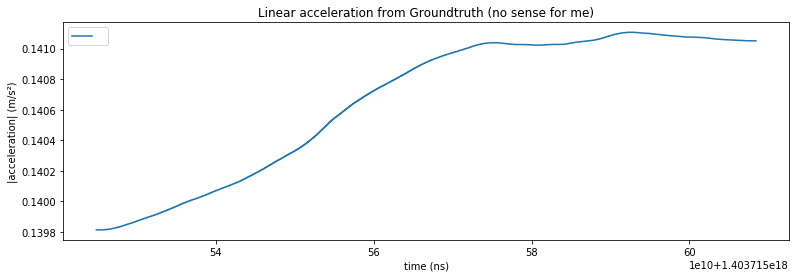

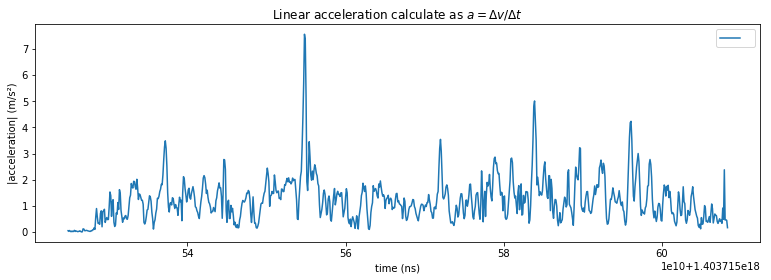

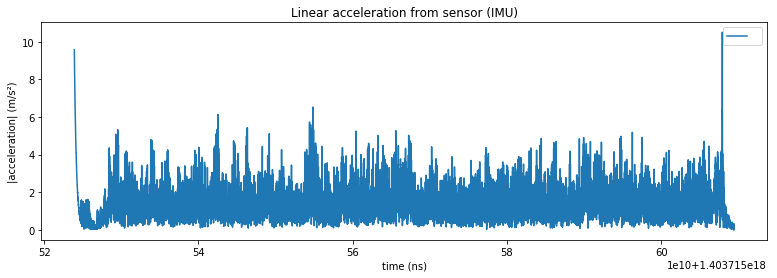

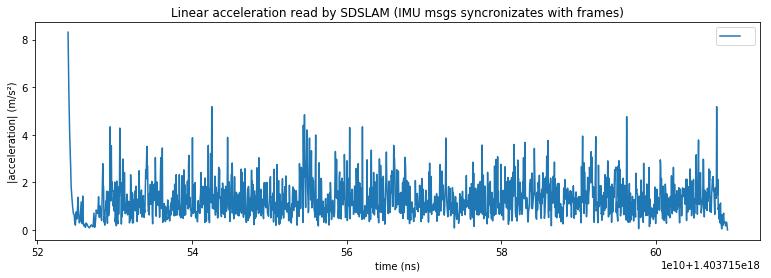

In [34]:
plot_module_data([module(gt, 'a')], [' '], title= 'Linear acceleration from Groundtruth (no sense for me)', x_label='time (ns)', y_label='|acceleration| (m/s²)')
plot_module_data([module(gt_acceleration, 'a')], [' '], title= 'Linear acceleration calculate as $a = \Delta v / \Delta t$', x_label='time (ns)', y_label='|acceleration| (m/s²)')
plot_module_data([module(imu_acceleration, 'a')], [' '], title= 'Linear acceleration from sensor (IMU)', x_label='time (ns)', y_label='|acceleration| (m/s²)')
plot_module_data([module(sdslam_imu_acceleration, 'a')], [' '], title= 'Linear acceleration read by SDSLAM (IMU msgs syncronizates with frames)', x_label='time (ns)', y_label='|acceleration| (m/s²)')

--- MSE of Acceleration ---
  x:  2.2970635850110357
  y:  1.4053594561513505
  z:  1.5391063265244282
 |a|: 12500448011879.068
---------------------------
--- STD of Acceleration ---
  x:  1.5152056550142827
  y:  1.185464082054919
  z:  1.2405565658992934
 |a|: 2500044.688631281
---------------------------


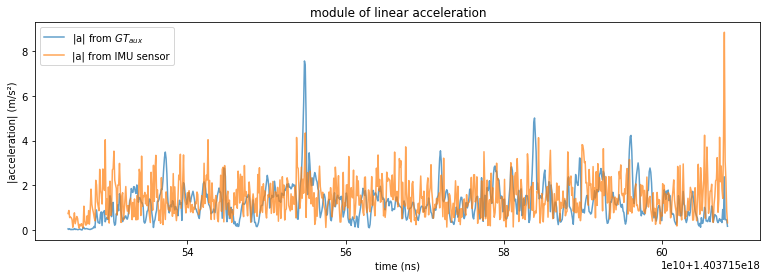

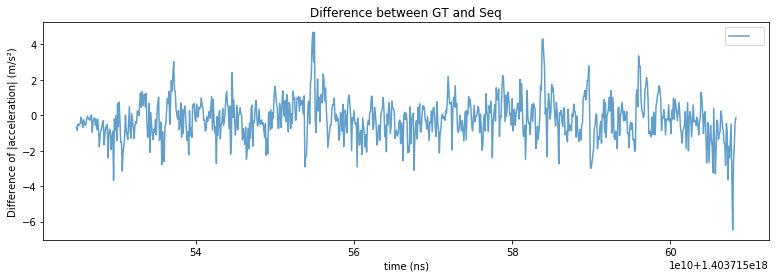

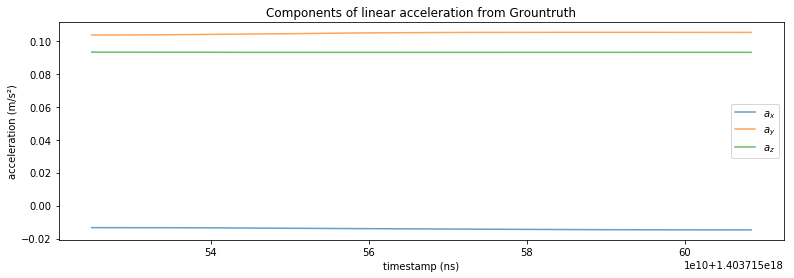

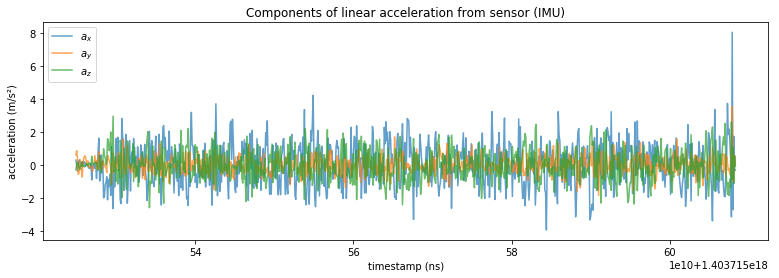

In [47]:
def sync_seqs(gt, seq):
    "Ajusta la secuencia seq(más datos) a gt(menos datos) 'temporalmente'"
    sync_seq = np.zeros(gt.shape, dtype=seq.dtype)
    n_elements = seq['timestamp'].shape[0]
    j = 0
    for i, t_gt in enumerate(gt['timestamp']):
        while (seq['timestamp'][j]) <= t_gt or j == n_elements:
            j+=1
        sync_seq[i] = seq[j]
    return sync_seq

def mse(seq_0, seq_1):    
    return np.sum((seq_0 - seq_1)**2) / seq_0.size

def std(seq_0, seq_1):
    return np.std(seq_0 - seq_1)

def print_mse_acceleration(seq_0, seq_1):
    mse_x = mse(seq_0['a_x'], seq_1['a_x'])
    mse_y = mse(seq_0['a_y'], seq_1['a_y'])
    mse_z = mse(seq_0['a_z'], seq_1['a_z'])
    mse_mod = mse(module(seq_0, 'a'), module(seq_1, 'a'))
    print('--- MSE of Acceleration ---')
    print(f'  x:  {mse_x}')
    print(f'  y:  {mse_y}')
    print(f'  z:  {mse_z}')
    print(f' |a|: {mse_mod}')
    print('---------------------------')

def print_std_acceleration(seq_0, seq_1):
    mse_x = std(seq_0['a_x'], seq_1['a_x'])
    mse_y = std(seq_0['a_y'], seq_1['a_y'])
    mse_z = std(seq_0['a_z'], seq_1['a_z'])
    mse_mod = std(module(seq_0, 'a'), module(seq_1, 'a'))
    print('--- STD of Acceleration ---')
    print(f'  x:  {mse_x}')
    print(f'  y:  {mse_y}')
    print(f'  z:  {mse_z}')
    print(f' |a|: {mse_mod}')
    print('---------------------------')

test = sync_seqs(gt_acceleration, imu_acceleration)
print_mse_acceleration(gt_acceleration, test)
print_std_acceleration(gt_acceleration, test)

plot_module_data([module(gt_acceleration, 'a'), module(test, 'a')], 
                 ['|a| from $GT_{aux}$', '|a| from IMU sensor'], alpha=0.7,
                 title= 'module of linear acceleration', x_label='time (ns)', y_label='|acceleration| (m/s²)')

a_ = module(gt_acceleration, 'a')
b_ = module(test, 'a')

plot_module_data([np.vstack((a_[:, 0], a_[:, 1] - b_[:, 1])).T], 
                 [' '], alpha=0.7,
                 title= 'Difference between GT and Seq', x_label='time (ns)', y_label='Difference of |acceleration| (m/s²)')
plot_components(gt, measure='a', title='Components of linear acceleration from Grountruth', alpha=0.7)
plot_components(test, measure='a', title='Components of linear acceleration from sensor (IMU)', alpha=0.7)

---

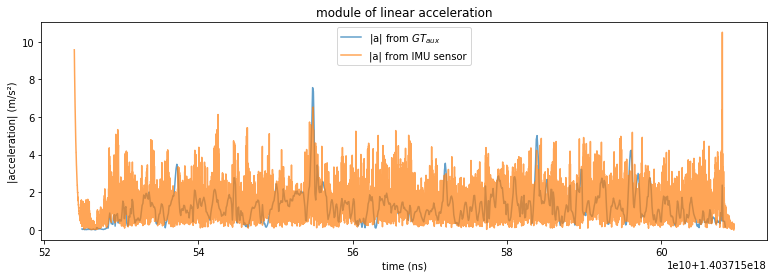

In [49]:
plot_module_data([module(gt_acceleration, 'a'), module(imu_acceleration, 'a')], 
                 ['|a| from $GT_{aux}$', '|a| from IMU sensor'], alpha=0.7,
                 title= 'module of linear acceleration', x_label='time (ns)', y_label='|acceleration| (m/s²)')

---


---
# Angular velocity (w)

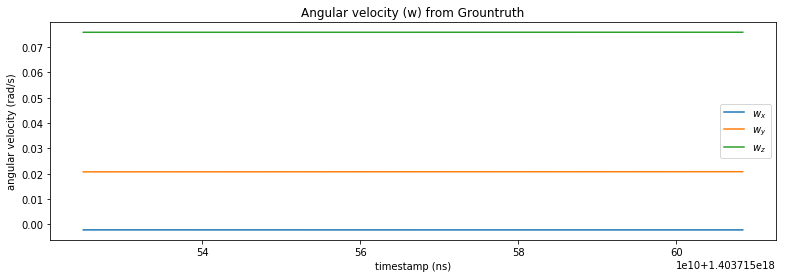

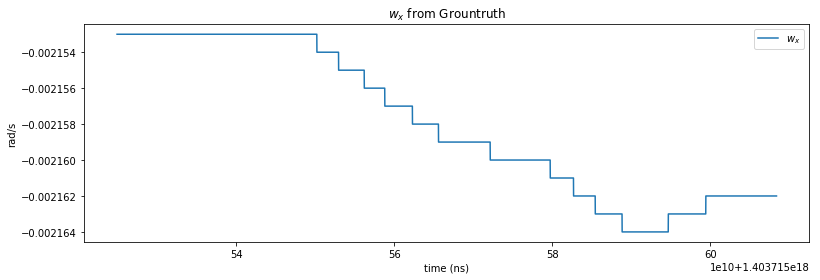

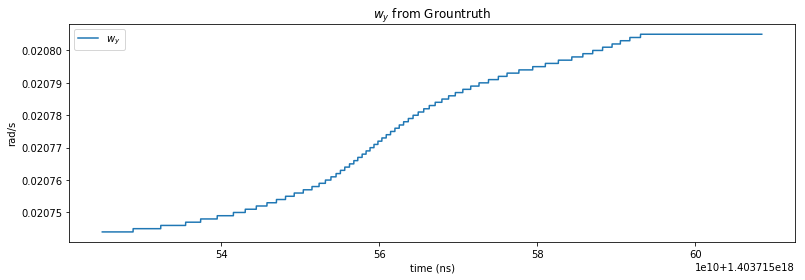

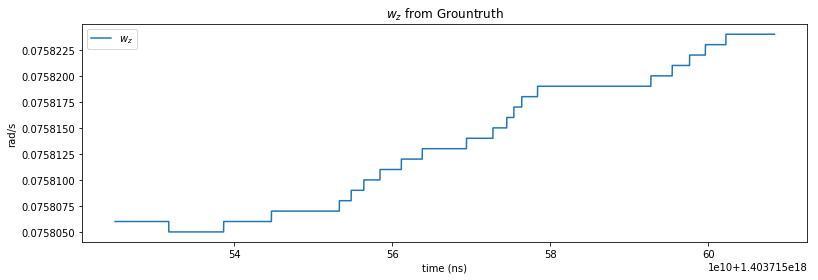

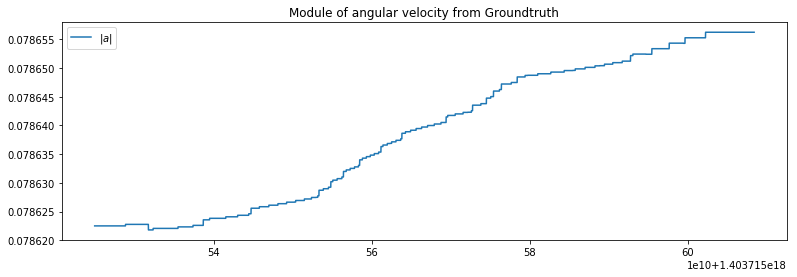

In [25]:
plot_components(gt, measure='w', title='Angular velocity (w) from Grountruth')
plot_data('timestamp', 'w_x', [gt], ['$w_x$'], title= '$w_x$ from Grountruth', x_label='time (ns)', y_label='rad/s')
plot_data('timestamp', 'w_y', [gt], ['$w_y$'], title= '$w_y$ from Grountruth', x_label='time (ns)', y_label='rad/s')
plot_data('timestamp', 'w_z', [gt], ['$w_z$'], title= '$w_z$ from Grountruth', x_label='time (ns)', y_label='rad/s')
plot_module_data([module(gt,'w')], ['$|a|$'], title= 'Module of angular velocity from Groundtruth')

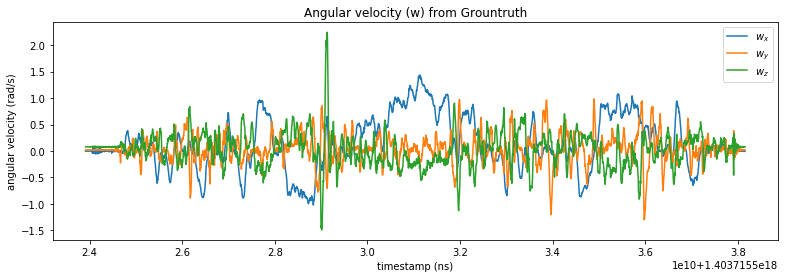

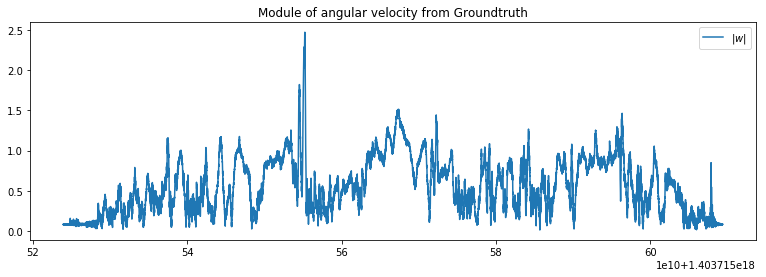

In [26]:
plot_components(imu_sync, measure='w', title='Angular velocity (w) from Grountruth')
plot_module_data([module(imu_sensor,'w')], ['$|w|$'], title= 'Module of angular velocity from Groundtruth')